### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from scipy.optimize import linprog
pd.set_option('display.max_columns', 1000)

### DataSet

In [55]:
# Load the dataset
file_path = "/kaggle/input/weekly-gc-data/weekly_dataset (1)(1).csv"
df1 = pd.read_csv(file_path)

# Relevant columns for averaging
rest_col = ['sla', 'is_holiday', 'is_sale', 'Max Temp (°C)', 'Min Temp (°C)',
            'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)',
            'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
            'Snow on Grnd (cm)', 'NPS', 'Stock Index', 'delivery_days_mean']

# Compute the average values
avg_values = df1[rest_col].mean()

# Given rest coefficients
rest_coeff = np.array([0.569223046, -0.210309312, 0.196929248, -0.0700256391,
                       -0.129011366, 0.244296853, 0.0624423946, -0.0741539006,
                       -0.156075021, -0.229624667, 0.114638032, -0.0226877609,
                       0.463617603, -0.116937289, 0.0000284028928])

# Compute the constant term
constant_term = np.sum(rest_coeff * avg_values)
constant_term


-23.678146900988366

In [ ]:
df = pd.read_csv('/kaggle/input/gc-data-mmm/merged_dataset_new.csv')

In [ ]:
df.head(6)

In [ ]:
df.drop(columns=['Unnamed: 0'],inplace=True)

#### DATA DESCRIPTION
* FSN ID: The unique identification of each SKU (SKU => Stock Keeping
Unit)
* Order Date: The date on which the order was placed
* Order ID: The unique identification number of each order
* Order item ID: Suppose you order 2 different products under the same
order, It generates 2 different order Item IDs under the same order ID;
orders are tracked by the Order Item ID.
* Deliverybdays: days to get item or order from warehouse for shipping
* Deliverycdays: days to deliver item to customer
* GMV: Gross Merchandise Value or Revenue
* Units: Number of units of the specific product sold
* Order payment type: How the order was paid – prepaid or cash on
delivery
* SLA: Number of days it typically takes to deliver the product
* Cust id: Unique identification of a customer
* Product MRP: Maximum retail price of the product
* Product procurement SLA: Time is typically taken to procure the product
* Media Spend: Monthly spending on various advertising channels
* Sale Calendar: Days when there was any special sale
* Monthly NPS score – this may work as a proxy to the ‘voice of the
customer’
* Stock Index of the company on a monthly basis
* Canada_holiday.xlsx: This helps to understand the holiday list for the
time period of data available
* FSN ID: The unique identification of each SKU
* Super_Category: Product Super Category Information
* Category: Product Category Information
* Sub_Category: Product Sub-Category Information
* Vertical: Product that belongs to which vertical

#### SOME IDEA
* List Price: List Price = GMV * Units

* Payday Week: If Payday falls within the week, then payday week = 1, else
0

* Holiday Week: If Holiday falls within the week, then payday week = 1,
else 0

* Product Type - Luxury /Mass-market: If GMV value is greater than 80
  percentile, then luxury, else mass-market
* Discount%: Discount% = 100*(product_mrp – list price) / product_mrp

In [ ]:
df['list_price'] = df.units * df.gmv

In [ ]:
df['discount'] = (df.product_mrp - df.list_price)/df.product_mrp

In [ ]:
df['is_luxury'] = (df['gmv'] > df['gmv'].quantile(0.8)).astype(int)

In [ ]:
df = df.sort_values(by="date", ascending=True)

In [ ]:
nps_stock_data = {
    'Year': [2023]*6 + [2024]*6,
    'Month': pd.to_datetime([
        '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
        '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01'
    ]),
    'NPS': [54.6, 60.0, 46.9, 44.4, 47.0, 45.8, 47.1, 50.3, 49.0, 51.8, 47.3, 50.5],
    'Stock Index': [1177, 1206, 1101, 1210, 1233, 1038, 1052, 1222, 1015, 1242, 1228, 1194],
    'Total Investment': [17.1, 5.1, 96.3, 170.2, 51.2, 106.7, 74.2, 48.1, 100.0, 56.8, 78.1, 42.8],
    'TV': [0.2, 0.0, 3.9, 6.1, 4.2, 5.4, 4.4, 2.6, 9.3, 5.2, 1.4, 1.7],
    'Digital': [2.5, 1.3, 1.4, 12.6, 1.3, 3.1, 0.5, 1.9, 2.1, 0.9, 0.8, 1.4],
    'Sponsorship': [7.4, 1.1, 62.8, 84.7, 14.2, 56.7, 4.2, 11.7, 41.6, 24.3, 31.7, 25.0],
    'Content Marketing': [0.0, 0.0, 0.6, 3.4, 0.2, 1.1, 0.9, 0.6, 0.4, 0.0, 0.8, 0.0],
    'Online Marketing': [1.3, 0.1, 16.4, 24.4, 19.6, 22.5, 22.9, 19.9, 18.4, 16.5, 23.7, 8.0],
    'Affiliates': [0.5, 0.1, 5.0, 7.0, 6.6, 6.8, 7.4, 6.5, 6.2, 5.7, 6.8, 2.8],
    'SEM': [5.0, 2.5, 6.2, 31.9, 5.2, 11.2, 4.2, 4.9, 5.2, 4.2, 6.9, 3.7],
    'Radio': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.7, 0.0, 0.9, 0.0, 1.1, 0.0],
    'Other': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.1, 0.0, 15.9, 0.0, 5.0, 0.0]
}
nps_stock_df = pd.DataFrame(nps_stock_data)
nps_stock_df['Month'] = nps_stock_df['Month'].dt.to_period('M')
df['date'] = pd.to_datetime(df['date']) 
df['Month'] = df['date'].dt.to_period('M') 
df = df.merge(nps_stock_df, on='Month', how='left')

In [ ]:
def is_payday_week(date):
    day = date.day
    return (1 <= day <= 7) or (15 <= day <= 21)

df['payday_week'] = df['date'].dt.day.between(1, 7) | df['date'].dt.day.between(15, 21)
df['payday_week'] = df['payday_week'].astype(int)

In [ ]:
nps_stock_df['Month'] = nps_stock_df['Month'].astype(str) 
plt.figure(figsize=(10, 5))
plt.plot(nps_stock_df['Month'], nps_stock_df['NPS'], marker='o', linestyle='-', label='NPS', color='blue')
# plt.plot(nps_stock_df['Month'], nps_stock_df['Stock Index'], marker='s', linestyle='--', label='Stock Index', color='red')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Time Series of NPS and Stock Index')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df = df.dropna(subset=['NPS'])

In [ ]:
df = df[df['product_procurement_sla'] >= 0]
df = df[df['deliverycdays']>=0]

In [ ]:
df['Total Investment'] = df['Total Investment_x']
df['Year'] = df['Year_x']
df.drop(columns = ['Total Investment_x','Total Investment_y','Year_x','Year_y'],inplace=True)

In [ ]:
df = df.sort_values(by="date", ascending=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.to_csv('compiled_data_gc.csv',index=False)

### Clean Data

In [2]:
df = pd.read_csv('/kaggle/input/gc-data-compiled/compiled_data_gc.csv')

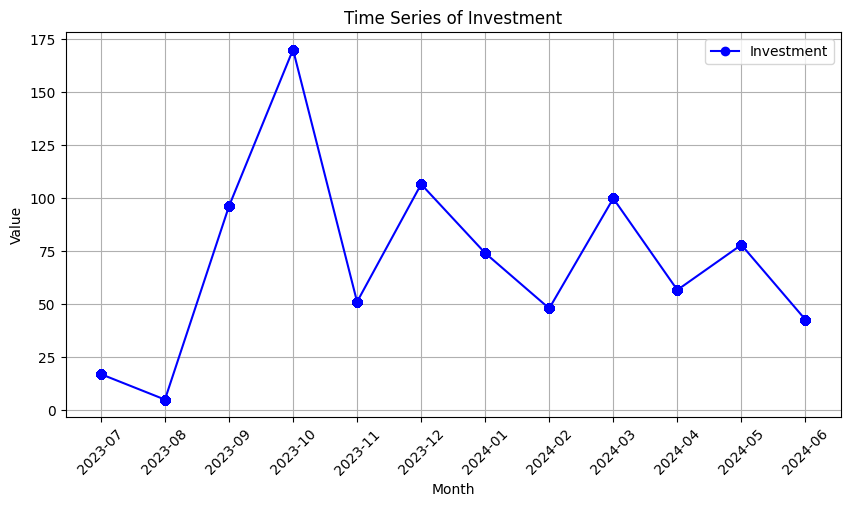

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(df['Month'], df['Total Investment'], marker='o', linestyle='-', label='Investment', color='blue')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Time Series of Investment')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df.columns

### KPI

In [ ]:
url ="https://colab.research.google.com/drive/1V1_mVl0T2RvgDcY7nkSza_O8NXNxOZ5d?usp=sharing#scrollTo=aXGhkX0OTYIh"

### EDA

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


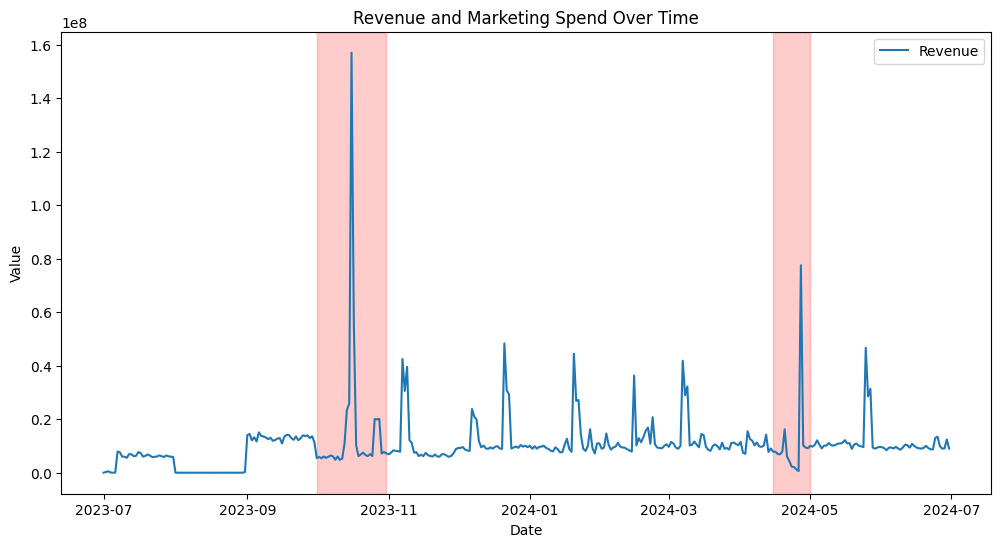

In [79]:
highlight_periods = [('2023-10-01', '2023-10-31'), ('2024-04-15', '2024-05-1')]
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_daily, x='date', y='gmv', label='Revenue')
# sns.lineplot(data=df_daily, x='date', y='Total Investment', label='Total Marketing Spend')

# Highlight October 2023 and May 2024 with red transparent circles
for start, end in highlight_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.2)

plt.title('Revenue and Marketing Spend Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [1]:
missing_values = df_daily.isnull().sum()

df_marketing = df_daily[['TV', 'Digital', 'Sponsorship', 'Content Marketing', 
                         'Online Marketing', 'Affiliates', 'SEM', 'Radio', 'Other', 'gmv']]

df_marketing = df_marketing.melt(id_vars=['gmv'], var_name='Marketing Channel', value_name='Spend')
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_marketing, x='Spend', y='gmv', hue='Marketing Channel')
plt.xscale('log')
plt.yscale('log')
plt.title('Revenue vs. Marketing Spend')
plt.show()

# 5. Seasonality Analysis
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_daily, x='date', y='gmv', label='Revenue')
sns.lineplot(data=df_daily, x='date', y='Total Investment', label='Total Marketing Spend')
plt.title('Revenue and Marketing Spend Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# 6. Discount Impact on Revenue
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_daily, x='discount_pct', y='gmv')
plt.title('Impact of Discount Percentage on Revenue')
plt.xlabel('Discount Percentage')
plt.ylabel('Revenue')
plt.show()

print("EDA Complete! Next step: Build the Marketing Mix Model (MMM)")


NameError: name 'df_daily' is not defined

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

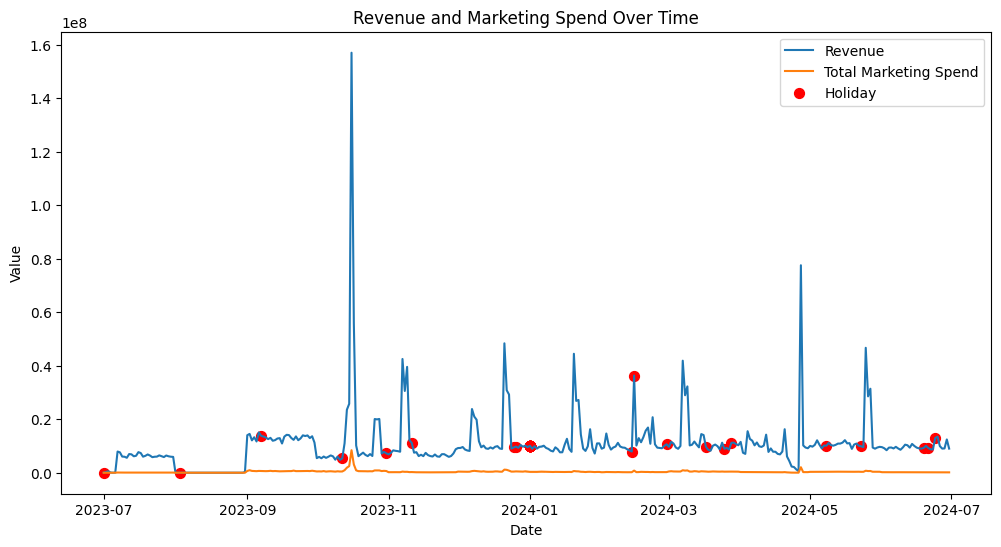

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Line plots for Revenue and Marketing Spend
sns.lineplot(data=df_daily, x='date', y='gmv', label='Revenue')
sns.lineplot(data=df_daily, x='date', y='Total Investment', label='Total Marketing Spend')

# Scatter plot for holidays
holiday_dates = df_daily[df_daily['is_holiday'] == 1]['date']
holiday_gmv = df_daily[df_daily['is_holiday'] == 1]['gmv']
plt.scatter(holiday_dates, holiday_gmv, color='red', label='Holiday', marker='o', s=50)

# Labels and title
plt.title('Revenue and Marketing Spend Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


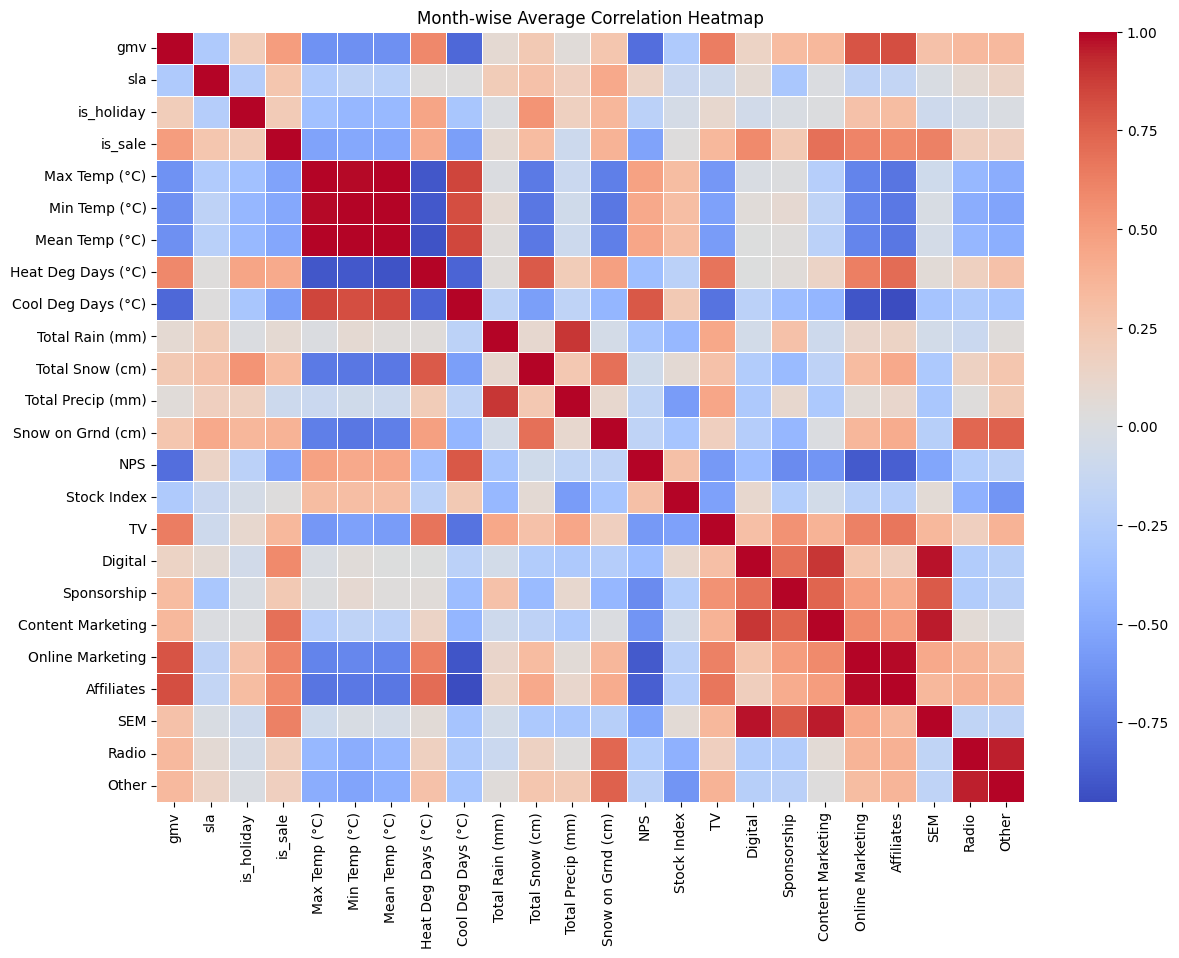

In [86]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract month from 'date'
df['Month'] = df['date'].dt.month

# Select only the required numerical columns
selected_columns = [
    'gmv', 'sla', 'is_holiday', 'is_sale', 'Max Temp (°C)', 'Min Temp (°C)', 
    'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 
    'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 
    'Snow on Grnd (cm)', 'NPS', 'Stock Index', 'TV', 'Digital', 'Sponsorship', 
    'Content Marketing', 'Online Marketing', 'Affiliates', 'SEM', 'Radio', 
    'Other'
]

# Ensure selected columns exist in the DataFrame
df_selected = df[['Month'] + selected_columns].dropna()

# Group by 'Month' and compute the mean
monthwise_avg = df_selected.groupby('Month').mean()

# Compute correlation matrix
corr_matrix = monthwise_avg.corr()

# Plot the heatmap without numbers
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Month-wise Average Correlation Heatmap")
plt.show()

* Strong Positive Correlations:

    * Online Marketing (0.798), Affiliates (0.823), TV (0.636), Heat Degree Days (0.592), Content Marketing (0.345):
        Marketing efforts, especially digital, affiliate, and TV campaigns, strongly impact GMV.
        Higher heat degree days (indicating colder weather) are positively associated with GMV, possibly due to increased online shopping.

* Moderate Positive Correlations:

    * Is Sale (0.494), Sponsorship (0.324), Snow on Ground (0.253):
        GMV increases during sales events.
        Sponsorships help boost sales, but not as much as direct marketing.
        More snow on the ground could be driving more online purchases.

* Strong Negative Correlations:

   * Cool Degree Days (-0.827), Min Temp (-0.639), Mean Temp (-0.636), Max Temp (-0.631):
        GMV is lower when temperatures are higher, suggesting that colder weather drives more online purchases.
    NPS (-0.797):
        A negative correlation with Net Promoter Score (NPS) could indicate that while sales volume increases, customer satisfaction may be impacted.

* Moderate Negative Correlations:

    * Stock Index (-0.266), Service Level Agreement (SLA) (-0.266):
        When stock market conditions are unfavorable, GMV tends to decrease.
        Higher SLA values (possibly indicating delays in service) may slightly reduce GMV.

In [36]:

print("Seasonality Component:\n", decomposition.seasonal)


Seasonality Component:
 date
2023-07-01    1.024882
2023-07-03    1.009618
2023-07-04    1.109633
2023-07-05    0.942792
2023-07-06    0.983041
                ...   
2024-06-26    0.944533
2024-06-27    1.024882
2024-06-28    1.009618
2024-06-29    1.109633
2024-06-30    0.942792
Name: seasonal, Length: 844, dtype: float64


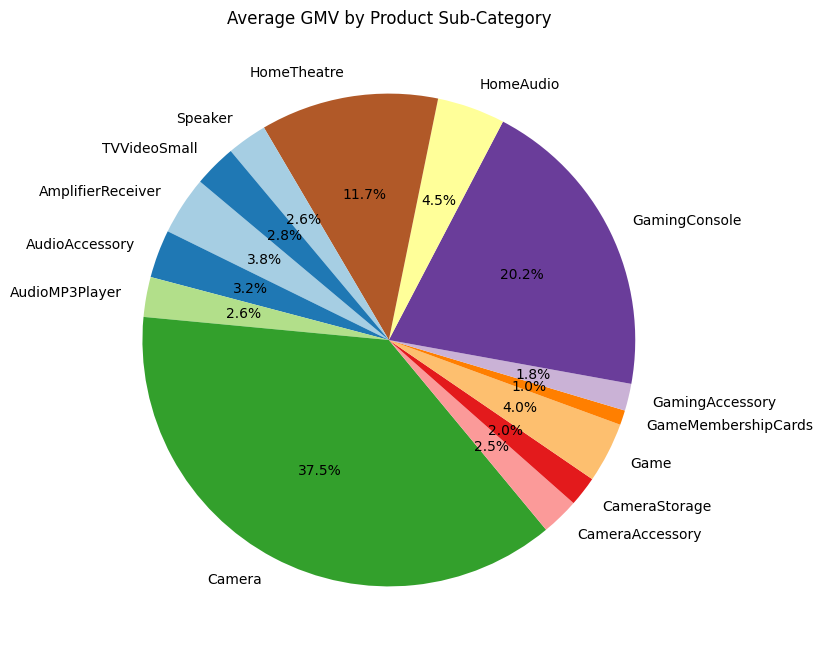

In [4]:
avg_gmv = df.groupby('product_analytic_sub_category')['gmv'].mean()

# Plotting pie chart
plt.figure(figsize=(8, 8))
plt.pie(avg_gmv, labels=avg_gmv.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Average GMV by Product Sub-Category')
plt.show()


In [6]:
avg_gmv = df.groupby('product_analytic_sub_category')['gmv'].mean()
avg_gmv

product_analytic_sub_category
AmplifierReceiver       1838.045667
AudioAccessory          1511.023551
AudioMP3Player          1253.654754
Camera                 17952.386441
CameraAccessory         1182.865719
CameraStorage            940.573866
Game                    1896.287493
GameMembershipCards      462.051546
GamingAccessory          847.624193
GamingConsole           9661.626134
HomeAudio               2134.155477
HomeTheatre             5584.056858
Speaker                 1257.740231
TVVideoSmall            1339.832769
Name: gmv, dtype: float64

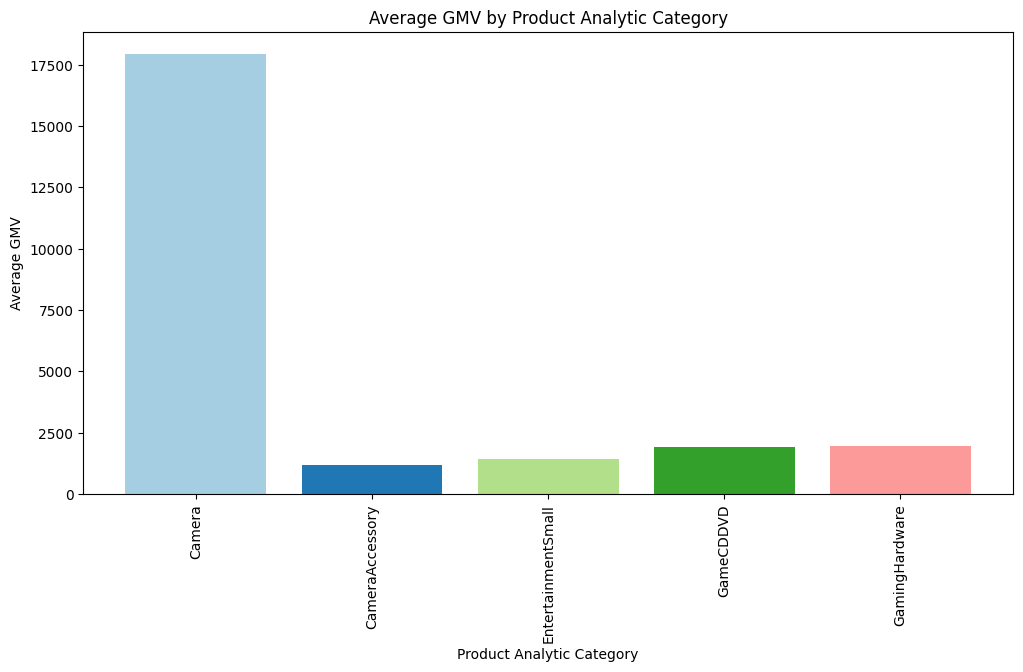

In [7]:
avg_gmv = df.groupby('product_analytic_category')['gmv'].mean()

# Plotting bar chart
plt.figure(figsize=(12, 6))
plt.bar(avg_gmv.index, avg_gmv, color=plt.cm.Paired.colors)
plt.xticks(rotation=90)
plt.xlabel('Product Analytic Category')
plt.ylabel('Average GMV')
plt.title('Average GMV by Product Analytic Category')
plt.show()


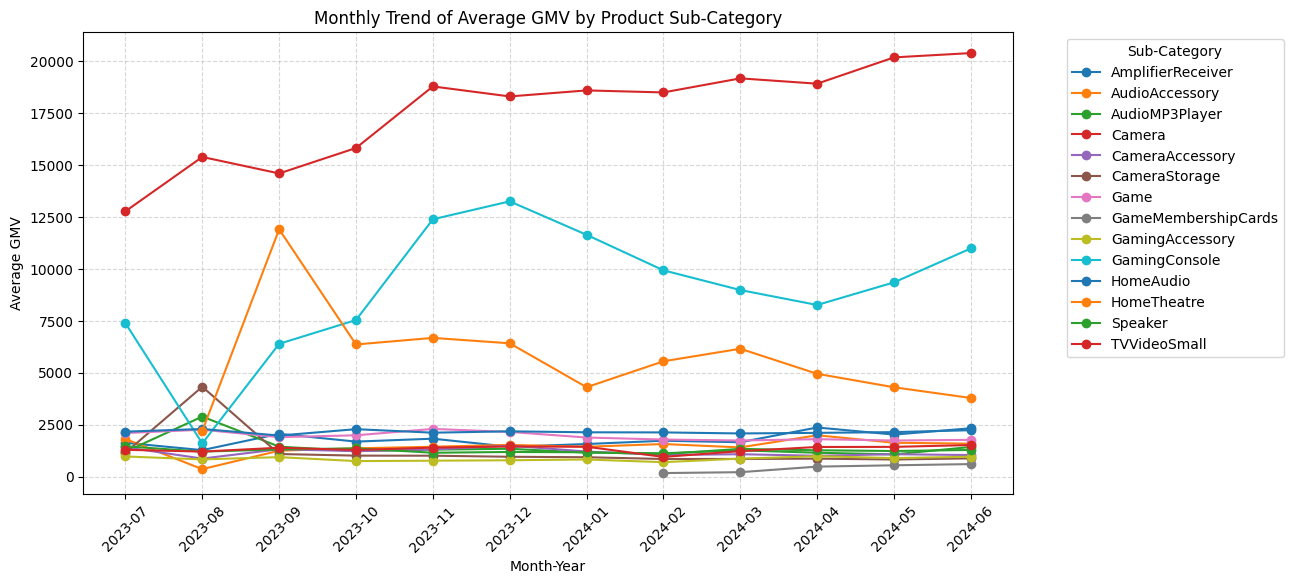

In [52]:
# Ensure 'month_year' is in string format
df['month_year'] = df['month_year'].astype(str)

# Calculating monthly average GMV per sub-category
df_trend_avg = df.groupby(['month_year', 'product_analytic_sub_category'])['gmv'].mean().unstack()

# Plotting trend line
plt.figure(figsize=(12, 6))
for category in df_trend_avg.columns:
    plt.plot(df_trend_avg.index.astype(str), df_trend_avg[category], marker='o', label=category)

plt.xticks(rotation=45)
plt.xlabel('Month-Year')
plt.ylabel('Average GMV')
plt.title('Monthly Trend of Average GMV by Product Sub-Category')
plt.legend(title='Sub-Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

* Month	     Accessory to Focus On	               Reason
* Jan-Feb	Camera, Camera Accessories	     Consistently high GMV
* Mar-Apr	Gaming Consoles, Gaming      Accessories	Demand starts rising
* May-Jun	AudioMP3 Players, Speakers	   Outdoor/travel demand increases
* Jul-Aug	Home Audio, Home Theatre	  Demand picks up before peak season
* Sep-Oct	Gaming Consoles, Home Theatre	Pre-festival shopping period
* Nov-Dec	Camera, Gaming Consoles	Holiday    season sales peak

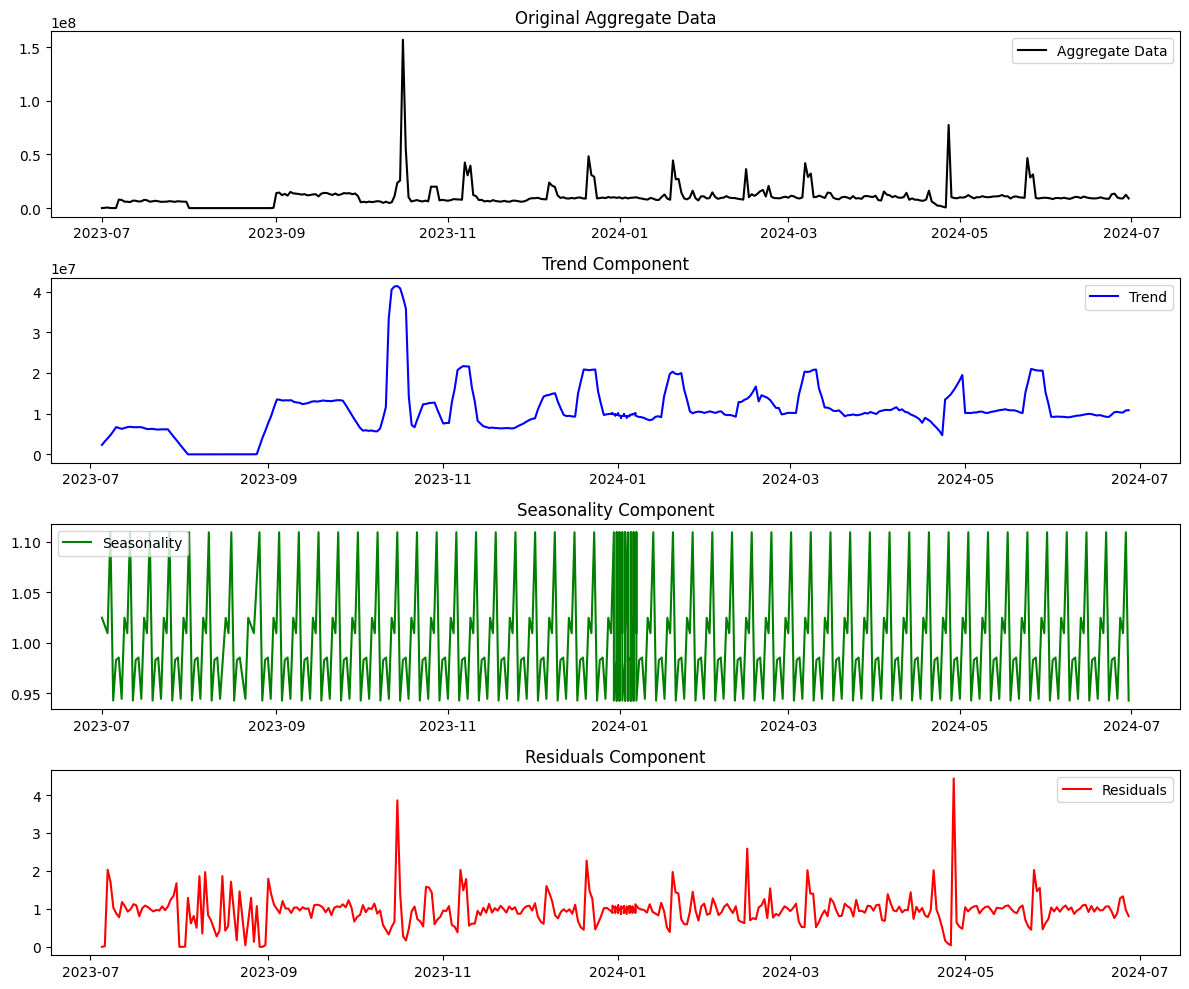

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Decomposing the time series
decomposition = seasonal_decompose(df_daily['gmv'], model='multiplicative', period=7)  # Assuming weekly seasonality

# Plot all components
plt.figure(figsize=(12, 10))

# 1. Original data
plt.subplot(4, 1, 1)
plt.plot(df_daily['gmv'], label='Aggregate Data', color='black')
plt.title('Original Aggregate Data')
plt.legend()

# 2. Trend component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.title('Trend Component')
plt.legend()

# 3. Seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonality Component')
plt.legend()

# 4. Residuals
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.title('Residuals Component')
plt.legend()

plt.tight_layout()
plt.show()